In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

# Download necessary NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yashp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# Load dataset
def load_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = ["English", "French"]
    df.dropna(inplace=True)
    return df

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

# Preprocess dataset
def preprocess_data(df):
    df["English"] = df["English"].apply(clean_text)
    df["French"] = df["French"].apply(clean_text)
    return df

# Tokenization
def tokenize_text(df):
    eng_tokens = [word_tokenize(sent) for sent in df['English']]
    fr_tokens = [word_tokenize(sent) for sent in df['French']]
    return eng_tokens, fr_tokens

# Build vocabulary
def build_vocab(tokenized_texts):
    vocab = {word for sentence in tokenized_texts for word in sentence}
    vocab = {word: idx + 1 for idx, word in enumerate(vocab)}
    vocab['<PAD>'] = 0
    return vocab

# Encode sentences
def encode_sentences(sentences, vocab, max_len):
    encoded = [[vocab.get(word, 0) for word in sent] for sent in sentences]
    padded = [sent + [0] * (max_len - len(sent)) if len(sent) < max_len else sent[:max_len] for sent in encoded]
    return np.array(padded)

# PyTorch Dataset Class
class TranslationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM Model Class
class LSTMTranslator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(LSTMTranslator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

# Load and process data
filepath = r"C:\Users\yashp\English to French Using LSTM\english_french.csv"
df = load_data(filepath)
df = preprocess_data(df)
eng_tokens, fr_tokens = tokenize_text(df)
eng_vocab = build_vocab(eng_tokens)
fr_vocab = build_vocab(fr_tokens)

# Set max sequence length
max_len = 10
X = encode_sentences(eng_tokens, eng_vocab, max_len)
y = encode_sentences(fr_tokens, fr_vocab, max_len)

In [7]:
df.head()

,English,French
0,go,va
1,go,marche
2,go,en route
3,go,bouge
4,hi,salut


In [8]:
df.tail()

,English,French
229798,death is something that were often discouraged...,la mort est une chose quon nous dcourage souve...
229799,since there are usually multiple websites on a...,puisquil y a de multiples sites web sur chaque...
229800,if someone who doesnt know your background say...,si quelquun qui ne connat pas vos antcdents di...
229801,it may be impossible to get a completely error...,il est peuttre impossible dobtenir un corpus c...
229802,i went drinking with one of my boyfriends frie...,je suis alle boire avec un ami de mon compagn...


In [23]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [24]:
# Prepare DataLoader
train_dataset = TranslationDataset(X_train, y_train)
val_dataset = TranslationDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [25]:
# Define Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTranslator(vocab_size=len(eng_vocab), embed_size=128, hidden_size=512, output_size=len(fr_vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}") # Get the name of the CUDA device
else:
    print("Using CPU")

print(f"Device type: {device.type}") # Print the type of device

Using CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Device type: cuda


In [27]:
'''# Training Loop
epochs = 40
train_losses, val_losses = [], []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")'''

'# Training Loop\nepochs = 40\ntrain_losses, val_losses = [], []\nfor epoch in range(epochs):\n    model.train()\n    total_loss = 0\n    for X_batch, y_batch in train_loader:\n        X_batch, y_batch = X_batch.to(device), y_batch.to(device)\n        optimizer.zero_grad()\n        output = model(X_batch)\n        loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))\n        loss.backward()\n        optimizer.step()\n        total_loss += loss.item()\n    train_losses.append(total_loss / len(train_loader))\n    \n    model.eval()\n    val_loss = 0\n    with torch.no_grad():\n        for X_batch, y_batch in val_loader:\n            X_batch, y_batch = X_batch.to(device), y_batch.to(device)\n            output = model(X_batch)\n            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))\n            val_loss += loss.item()\n    val_losses.append(val_loss / len(val_loader))\n    \n    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Lo

In [28]:
from tqdm import tqdm

epochs = 30
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for X_batch, y_batch in progress_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Update progress bar with loss info
        progress_bar.set_postfix(loss=loss.item())

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")



Epoch 1/30 | Train Loss: 2.7712 | Val Loss: 2.3145


Epoch 2/30 | Train Loss: 1.9962 | Val Loss: 2.1650


Epoch 3/30 | Train Loss: 1.7092 | Val Loss: 2.1362


Epoch 4/30 | Train Loss: 1.5338 | Val Loss: 2.1484


Epoch 5/30 | Train Loss: 1.4193 | Val Loss: 2.1699


Epoch 6/30 | Train Loss: 1.3370 | Val Loss: 2.2014


Epoch 7/30 | Train Loss: 1.2743 | Val Loss: 2.2279


Epoch 8/30 | Train Loss: 1.2253 | Val Loss: 2.2610


Epoch 9/30 | Train Loss: 1.1860 | Val Loss: 2.2933


Epoch 10/30 | Train Loss: 1.1541 | Val Loss: 2.3192


Epoch 11/30 | Train Loss: 1.1277 | Val Loss: 2.3480


Epoch 12/30 | Train Loss: 1.1059 | Val Loss: 2.3824


Epoch 13/30 | Train Loss: 1.0885 | Val Loss: 2.4054


Epoch 14/30 | Train Loss: 1.0730 | Val Loss: 2.4263


Epoch 15/30 | Train Loss: 1.0605 | Val Loss: 2.4484


Epoch 16/30 | Train Loss: 1.0485 | Val Loss: 2.4678


Epoch 17/30 | Train Loss: 1.0402 | Val Loss: 2.4861


Epoch 18/30 | Train Loss: 1.0309 | Val Loss: 2.5073


Epoch 19/30 | Train Loss: 1.0231 | Val Loss: 2.5212


Epoch 20/30 | Train Loss: 1.0173 | Val Loss: 2.5397


Epoch 21/30 | Train Loss: 1.0118 | Val Loss: 2.5596


Epoch 22/30 | Train Loss: 1.0072 | Val Loss: 2.5720


Epoch 23/30 | Train Loss: 1.0023 | Val Loss: 2.5864


Epoch 24/30 | Train Loss: 1.0001 | Val Loss: 2.5921


Epoch 25/30 | Train Loss: 0.9960 | Val Loss: 2.6112


Epoch 26/30 | Train Loss: 0.9935 | Val Loss: 2.6203


Epoch 27/30 | Train Loss: 0.9909 | Val Loss: 2.6406


Epoch 28/30 | Train Loss: 0.9881 | Val Loss: 2.6440


Epoch 29/30 | Train Loss: 0.9869 | Val Loss: 2.6544


Epoch 30/30 | Train Loss: 0.9854 | Val Loss: 2.6629


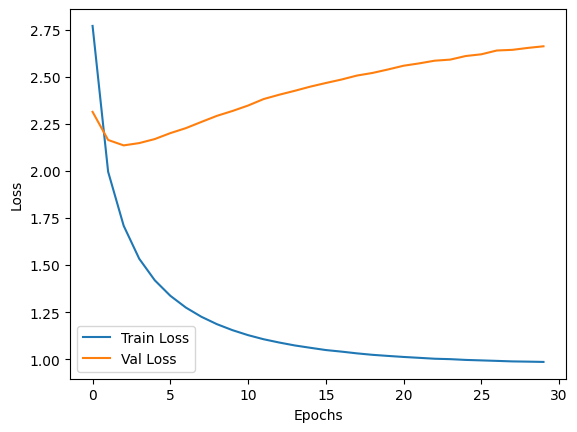

In [29]:
# Plot Loss Curve
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Save Model and Files
torch.save(model.state_dict(), "translator_model.pth")
pd.to_pickle(eng_vocab, "eng_vocab.pkl")
pd.to_pickle(fr_vocab, "fr_vocab.pkl")
